# Simple LSTM for track finding on 1D detector layers

In [1]:
# System imports
from __future__ import print_function

# External imports
import numpy as np
from keras import models
from keras import layers

# Local imports
from data import (generate_straight_track, generate_straight_tracks,
                  generate_uniform_noise, generate_track_bkg)
from drawing import draw_2d_event, draw_2d_input_and_pred

from matplotlib import pyplot as plt
%matplotlib notebook

Using TensorFlow backend.


## Data generation

In [2]:
# Config parameters
det_width = 50
det_depth = 50
det_shape = (det_depth, det_width)
num_events = 100000

In [3]:
# Generate a sample of single-track events
tracks = generate_straight_tracks(num_events, det_shape)
train_input = tracks
train_target = tracks
print(train_input.shape)

(100000, 50, 50)


## Simple LSTM track fitting model

In [4]:
def build_model(num_hidden=10, length=det_depth, dim=det_width,
                loss='categorical_crossentropy',
                optimizer='Nadam', metrics=['accuracy']):
    inputs = layers.Input(shape=(length, dim))
    hidden = layers.LSTM(output_dim=num_hidden, return_sequences=True)(inputs)
    outputs = layers.TimeDistributed(layers.Dense(dim, activation='softmax'))(hidden)
    model = models.Model(input=inputs, output=outputs)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

In [5]:
# Instantiate the model
model1 = build_model()
# Train on the entire training set
model1.fit(train_input, train_target, batch_size=500, nb_epoch=10)
# Get all of the training data predictions
train_pred = model1.predict(train_input)

Epoch 1/10
100000/100000 [==============================] - 17s - loss: 3.0673 - acc: 0.2933    
Epoch 2/10
100000/100000 [==============================] - 15s - loss: 1.3478 - acc: 0.8297    
Epoch 3/10
100000/100000 [==============================] - 16s - loss: 0.5097 - acc: 0.9823    
Epoch 4/10
100000/100000 [==============================] - 16s - loss: 0.2161 - acc: 0.9984    
Epoch 5/10
100000/100000 [==============================] - 16s - loss: 0.1082 - acc: 0.9998    
Epoch 6/10
100000/100000 [==============================] - 16s - loss: 0.0644 - acc: 0.9999    
Epoch 7/10
100000/100000 [==============================] - 16s - loss: 0.0430 - acc: 1.0000    
Epoch 8/10
100000/100000 [==============================] - 15s - loss: 0.0309 - acc: 1.0000    
Epoch 9/10
100000/100000 [==============================] - 15s - loss: 0.0233 - acc: 1.0000    
Epoch 10/10
100000/100000 [==============================] - 16s - loss: 0.0182 - acc: 1.0000    


<IPython.core.display.Javascript object>


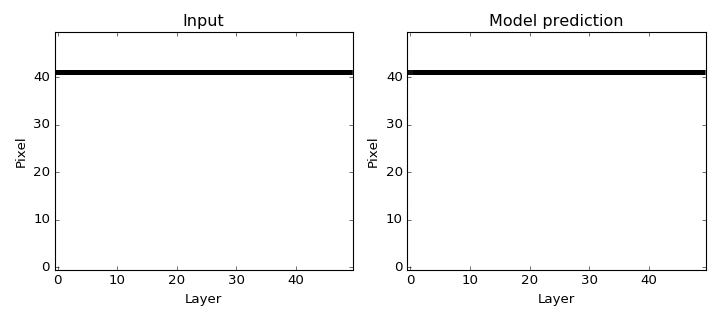

In [21]:
# Display one sample from the training set
display_idx = 10
draw_2d_input_and_pred(train_input[display_idx], train_pred[display_idx], cmap='gray_r');

## Two-track events

<IPython.core.display.Javascript object>


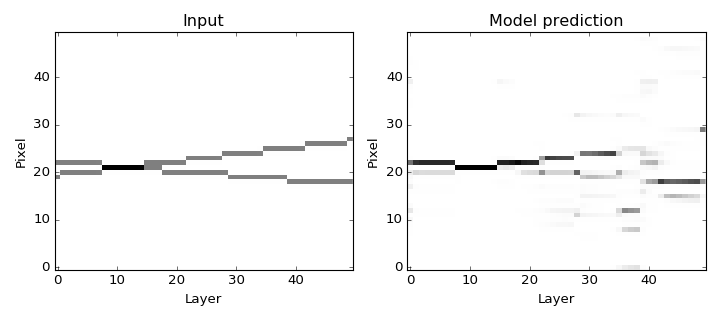

In [22]:
# Try adding two tracks into one image and see how the model does without any retraining
t1 = generate_straight_track(det_shape)
t2 = generate_straight_track(det_shape)
t3 = t1 + t2
t3_input = np.expand_dims(t3, 0)
t3_pred = model1.predict(t3_input)

# Plot the event and the corresponding prediction
draw_2d_input_and_pred(t3, t3_pred[0], cmap='gray_r');

In [8]:
# Now lets generate events with 2 tracks each and train on that
events2 = sum([generate_straight_tracks(50000, det_shape) for i in range(2)])
train2_input = events2
train2_target = events2

In [9]:
# Create a new model
model2 = build_model(num_hidden=20)
model2.fit(train2_input, train2_target, batch_size=500, nb_epoch=10)
train2_pred = model2.predict(train2_input)

Epoch 1/10
50000/50000 [==============================] - 8s - loss: 6.7922 - acc: 0.1891     
Epoch 2/10
50000/50000 [==============================] - 8s - loss: 4.2613 - acc: 0.4316     
Epoch 3/10
50000/50000 [==============================] - 8s - loss: 2.8011 - acc: 0.4829     
Epoch 4/10
50000/50000 [==============================] - 8s - loss: 2.1616 - acc: 0.4980     
Epoch 5/10
50000/50000 [==============================] - 8s - loss: 1.8693 - acc: 0.5063     
Epoch 6/10
50000/50000 [==============================] - 8s - loss: 1.7169 - acc: 0.5086     
Epoch 7/10
50000/50000 [==============================] - 8s - loss: 1.6279 - acc: 0.5090     
Epoch 8/10
50000/50000 [==============================] - 8s - loss: 1.5708 - acc: 0.5101     
Epoch 9/10
50000/50000 [==============================] - 8s - loss: 1.5315 - acc: 0.5112     
Epoch 10/10
50000/50000 [==============================] - 8s - loss: 1.5029 - acc: 0.5126     


<IPython.core.display.Javascript object>


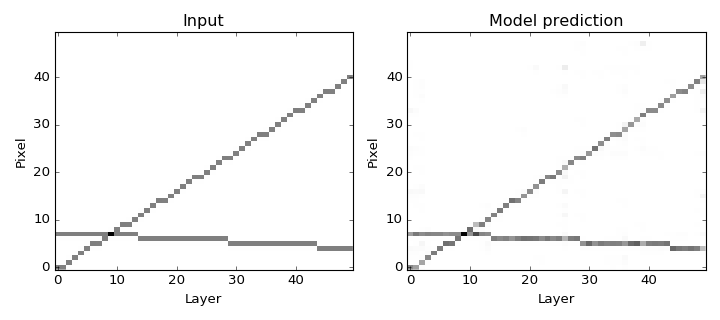

In [20]:
# Display one sample from the training set
display_idx = 666
draw_2d_input_and_pred(events2[display_idx], train2_pred[display_idx], cmap='gray_r');

## Single tracks with uniform noise
In training, the inputs to the network are the events with the tracks and noise. However, in this case the target is the not same event, but rather the track by itself (still shifted by 1 index). Let's see if we can get this to work.

<IPython.core.display.Javascript object>


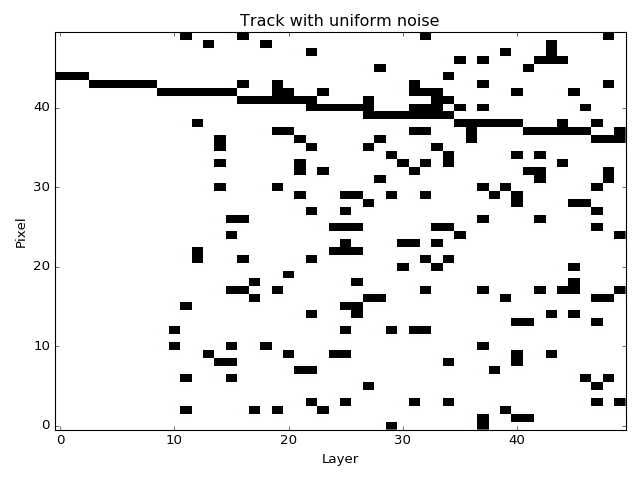

In [11]:
noise = generate_uniform_noise(len(tracks), det_shape, skip_layers=10)
events3 = tracks + noise
events3[events3 > 1] = 1

# Define the inputs and target
train3_input = events3
train3_target = tracks

# Let's take a quick look at one of these noise events
plt.figure()
draw_2d_event(events3[66], title='Track with uniform noise', cmap='gray_r')

In [12]:
# Instantiate the model
model3 = build_model(num_hidden=50)
# Train the network
model3.fit(train3_input, train3_target, batch_size=500, nb_epoch=10)
# Get the final predictions from the entire training set
train3_pred = model3.predict(train3_input)

Epoch 1/10
100000/100000 [==============================] - 17s - loss: 2.0068 - acc: 0.5397    
Epoch 2/10
100000/100000 [==============================] - 16s - loss: 0.5758 - acc: 0.8785    
Epoch 3/10
100000/100000 [==============================] - 16s - loss: 0.2931 - acc: 0.9310    
Epoch 4/10
100000/100000 [==============================] - 16s - loss: 0.2280 - acc: 0.9411    
Epoch 5/10
100000/100000 [==============================] - 16s - loss: 0.1599 - acc: 0.9537    
Epoch 6/10
100000/100000 [==============================] - 16s - loss: 0.1316 - acc: 0.9596    
Epoch 7/10
100000/100000 [==============================] - 16s - loss: 0.1214 - acc: 0.9623    
Epoch 8/10
100000/100000 [==============================] - 16s - loss: 0.1110 - acc: 0.9630    
Epoch 9/10
100000/100000 [==============================] - 16s - loss: 0.0941 - acc: 0.9676    
Epoch 10/10
100000/100000 [==============================] - 16s - loss: 0.0858 - acc: 0.9699    


In [ ]:
display_idx = 12050
draw_2d_input_and_pred(events3[display_idx], train3_pred[display_idx], cmap='gray_r')

let's try to make it a little more difficult by decreasing the seed size and increasing the noise level

<IPython.core.display.Javascript object>


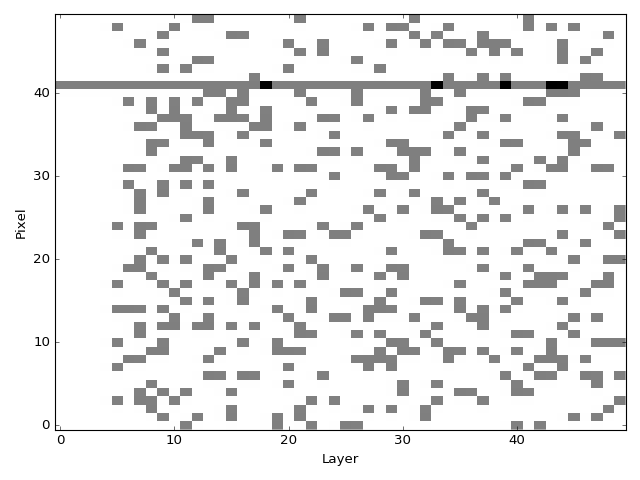

In [14]:
noise = generate_uniform_noise(len(tracks), det_shape, skip_layers=5, prob=0.2)
events4 = tracks + noise
train4_input = events4
train4_target = tracks
plt.figure()
draw_2d_event(events4[10], cmap='gray_r')

In [15]:
model4 = build_model(num_hidden=50)
model4.fit(train4_input, train4_target, batch_size=500, nb_epoch=10)
train4_pred = model4.predict(train4_input)

Epoch 1/10
100000/100000 [==============================] - 17s - loss: 2.3658 - acc: 0.4207    
Epoch 2/10
100000/100000 [==============================] - 16s - loss: 1.0281 - acc: 0.7279    
Epoch 3/10
100000/100000 [==============================] - 16s - loss: 0.6497 - acc: 0.8203    
Epoch 4/10
100000/100000 [==============================] - 16s - loss: 0.4533 - acc: 0.8675    
Epoch 5/10
100000/100000 [==============================] - 16s - loss: 0.3775 - acc: 0.8872    
Epoch 6/10
100000/100000 [==============================] - 16s - loss: 0.3087 - acc: 0.9028    
Epoch 7/10
100000/100000 [==============================] - 16s - loss: 0.2680 - acc: 0.9129    
Epoch 8/10
100000/100000 [==============================] - 16s - loss: 0.2534 - acc: 0.9170    
Epoch 9/10
100000/100000 [==============================] - 16s - loss: 0.2400 - acc: 0.9192    
Epoch 10/10
100000/100000 [==============================] - 16s - loss: 0.2053 - acc: 0.9283    


In [ ]:
display_idx = 0
draw_2d_input_and_pred(events4[display_idx], train4_pred[display_idx], cmap='gray_r')

display_idx = 1
draw_2d_input_and_pred(events4[display_idx], train4_pred[display_idx], cmap='gray_r');

## Multi-track background

Now let's try the scenario where each event has background tracks in addition to the signal track.

In [17]:
# Generate the bkg data
bkgs = generate_track_bkg(tracks.shape[0], det_shape, tracks_per_event=5)
events5 = bkgs + tracks
events5[events5 > 1] = 1
train5_input = events5
train5_target = tracks

In [18]:
model5 = build_model(num_hidden=100)
model5.fit(train5_input, train5_target, batch_size=200, nb_epoch=10)
train5_pred = model5.predict(train5_input)

Epoch 1/10
100000/100000 [==============================] - 33s - loss: 1.7725 - acc: 0.4756    
Epoch 2/10
100000/100000 [==============================] - 33s - loss: 0.7641 - acc: 0.7341    
Epoch 3/10
100000/100000 [==============================] - 33s - loss: 0.5448 - acc: 0.8085    
Epoch 4/10
100000/100000 [==============================] - 33s - loss: 0.4505 - acc: 0.8413    
Epoch 5/10
100000/100000 [==============================] - 33s - loss: 0.4115 - acc: 0.8559    
Epoch 6/10
100000/100000 [==============================] - 33s - loss: 0.3794 - acc: 0.8672    
Epoch 7/10
100000/100000 [==============================] - 33s - loss: 0.3355 - acc: 0.8814    
Epoch 8/10
100000/100000 [==============================] - 33s - loss: 0.3198 - acc: 0.8880    
Epoch 9/10
100000/100000 [==============================] - 33s - loss: 0.3179 - acc: 0.8892    
Epoch 10/10
100000/100000 [==============================] - 33s - loss: 0.2920 - acc: 0.8974    


<IPython.core.display.Javascript object>


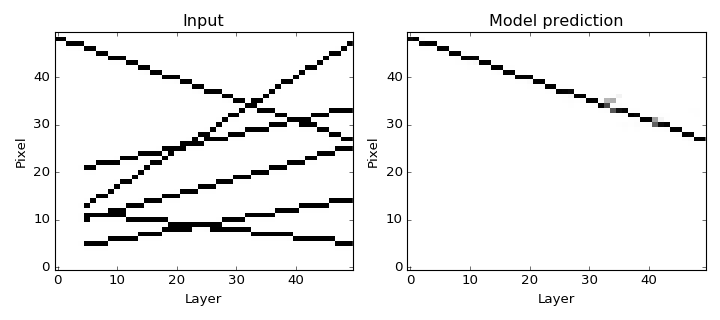

<IPython.core.display.Javascript object>


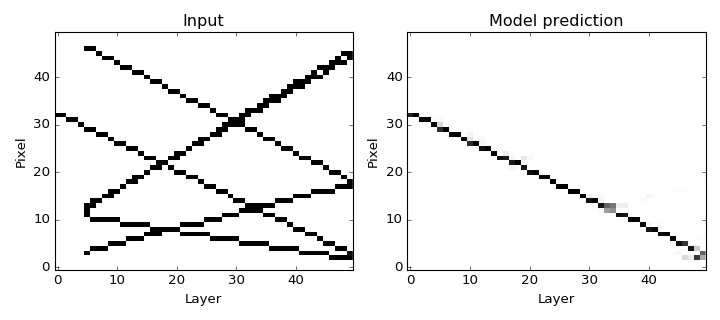

<IPython.core.display.Javascript object>


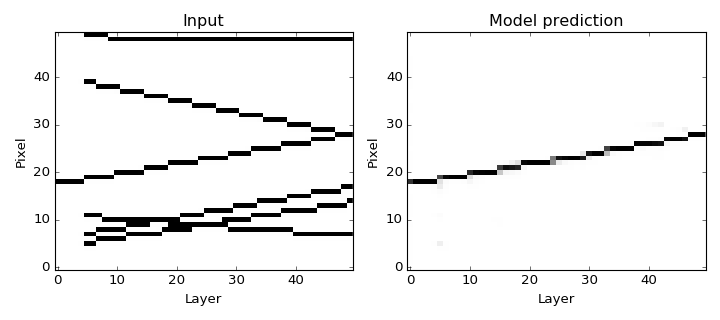

In [23]:
display_idx = 1234
draw_2d_input_and_pred(events5[display_idx], train5_pred[display_idx], cmap='gray_r');
display_idx = 5432
draw_2d_input_and_pred(events5[display_idx], train5_pred[display_idx], cmap='gray_r');
display_idx = 666
draw_2d_input_and_pred(events5[display_idx], train5_pred[display_idx], cmap='gray_r');

## Smoother LSTM
Here's a model which does a forward LSTM pass followed by a reverse pass over the outputs.
The goal is to refine and smooth the estimate.

In [32]:
def reverse_func(x):
    import keras.backend as K
    assert K.ndim(x) == 3, "Should be a 3D tensor."
    rev = K.permute_dimensions(x, (1, 0, 2))[::-1]
    return K.permute_dimensions(rev, (1, 0, 2))

def build_smooth_model(num_hidden=10, length=det_depth, dim=det_width,
                       loss='categorical_crossentropy',
                       optimizer='Nadam', metrics=['accuracy']):
    inputs = layers.Input(shape=(length, dim))
    # Forward pass LSTM + FC
    hidden = layers.LSTM(output_dim=num_hidden, return_sequences=True)(inputs)
    hidden = layers.TimeDistributed(layers.Dense(dim, activation='softmax'))(hidden)
    # Backwards pass LSTM + FC smoother
    hidden = layers.LSTM(output_dim=num_hidden, return_sequences=True, go_backwards=True)(hidden)
    # Reverse sequence order to match input order
    hidden = layers.Lambda(reverse_func)(hidden)
    outputs = layers.TimeDistributed(layers.Dense(dim, activation='softmax'))(hidden)
    model = models.Model(input=inputs, output=outputs)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

In [33]:
train6_input = events5
train6_target = tracks

In [34]:
model6 = build_smooth_model(num_hidden=100)
model6.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_4 (InputLayer)             (None, 50, 50)        0                                            
____________________________________________________________________________________________________
lstm_7 (LSTM)                    (None, 50, 100)       60400       input_4[0][0]                    
____________________________________________________________________________________________________
timedistributed_7 (TimeDistribute(None, 50, 50)        5050        lstm_7[0][0]                     
____________________________________________________________________________________________________
lstm_8 (LSTM)                    (None, 50, 100)       60400       timedistributed_7[0][0]          
___________________________________________________________________________________________

In [35]:
model6.fit(train6_input, train6_target, batch_size=200, nb_epoch=10)
train6_pred = model6.predict(train6_input)

Epoch 1/10
100000/100000 [==============================] - 105s - loss: 3.5697 - acc: 0.0439   
Epoch 2/10
100000/100000 [==============================] - 105s - loss: 3.1851 - acc: 0.0754   
Epoch 3/10
100000/100000 [==============================] - 105s - loss: 2.9082 - acc: 0.1050   
Epoch 4/10
100000/100000 [==============================] - 105s - loss: 2.7247 - acc: 0.1253   
Epoch 5/10
100000/100000 [==============================] - 105s - loss: 2.5476 - acc: 0.1470   
Epoch 6/10
100000/100000 [==============================] - 105s - loss: 2.4071 - acc: 0.1738   
Epoch 7/10
100000/100000 [==============================] - 105s - loss: 2.2814 - acc: 0.2012   
Epoch 8/10
100000/100000 [==============================] - 105s - loss: 2.1894 - acc: 0.2241   
Epoch 9/10
100000/100000 [==============================] - 105s - loss: 2.0973 - acc: 0.2454   
Epoch 10/10
100000/100000 [==============================] - 105s - loss: 2.1026 - acc: 0.2568   


<IPython.core.display.Javascript object>


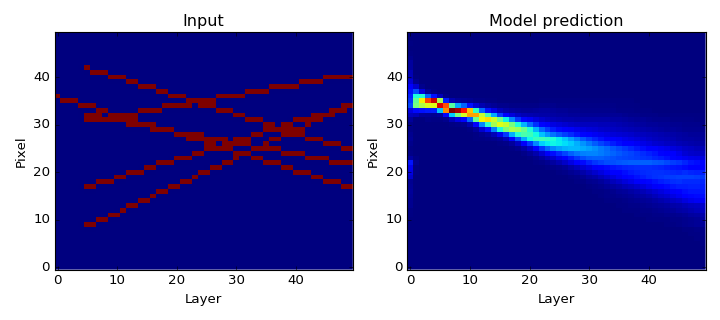

<IPython.core.display.Javascript object>


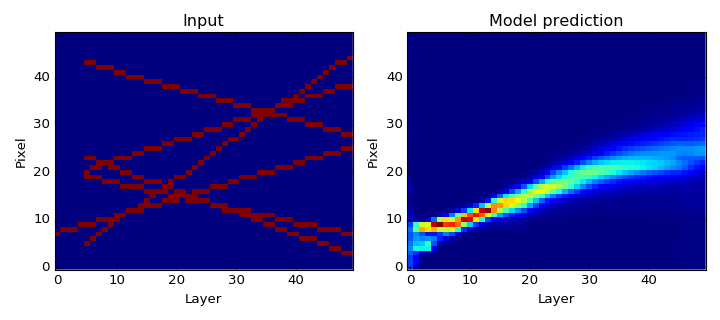

<IPython.core.display.Javascript object>


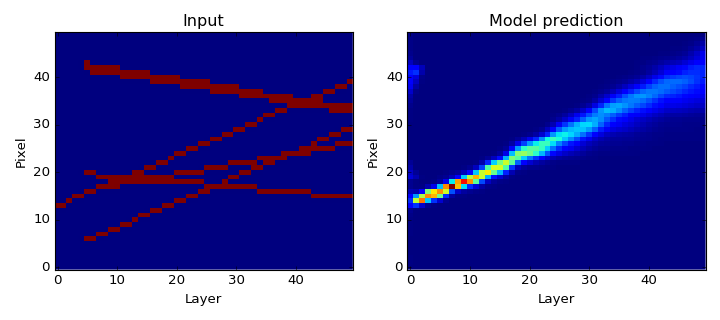

In [36]:
display_idx = 1234
draw_2d_input_and_pred(train6_input[display_idx], train6_pred[display_idx])
display_idx = 5432
draw_2d_input_and_pred(train6_input[display_idx], train6_pred[display_idx])
display_idx = 666
draw_2d_input_and_pred(train6_input[display_idx], train6_pred[display_idx])